<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/training_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from copy import deepcopy
import csv

from torch.autograd import Variable
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import matplotlib

!pip install nlopt
import nlopt
from numpy import *
import numpy as np

     |████████████████████████████████| 420 kB 7.3 MB/s 


# Various modelling parameters

In [3]:
# N is batch size; D_in is input dimension;
# H is the dimension of the hidden layer; D_out is output dimension.
N, D_in, H_teacher, H_student, D_out = 1, 2, 4, 5, 1
num_experiments = 1

# Dataset creation

In [4]:
def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

data = torch.DoubleTensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Models

## Teacher's model

In [5]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

## Student's model

In [6]:
class StudentNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(StudentNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False).double()
    self.linear2 = nn.Linear(H, D_out, bias=False).double()
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

## Dummy network used for evaluationg the loss from given weights

In [7]:
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False).double()
    self.linear2 = nn.Linear(H, D_out, bias=False).double()
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Generation of the labels based on the teacher model.

In [8]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(data).detach()

# Perturbation training helper

In [9]:
# def train_by_perturbation(eps, num_iter):
#     for i in range(0, num_iter):
#         mu, sigma = 0, 0.1
#         perturbation = eps * np.random.normal(mu, sigma, H_student * D_in).astype(np.float64).reshape((H_student, D_in))
        
#         # Perturb the weights of the NN.
#         params = OrderedDict([("w_in", torch.Tensor(trace[-1][0] + perturbation)),
#                               ("w_out", torch.Tensor(trace[-1][1]))])
        
#         # Set the bounds for second-order optimization.
#         lb_dict = OrderedDict([("w_in", torch.Tensor(trace[-1][0] - 0.3 + perturbation)), 
#                                ("w_out", torch.Tensor(trace[-1][1] - 1))])
#         ub_dict = OrderedDict([("w_in", torch.Tensor(trace[-1][0] + 0.3 + perturbation)),
#                                ("w_out", torch.Tensor(trace[-1][1] + 1))])
        
#         # Perform second-order optimization.
#         params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 4}, tol=1e-40)
        
#         # Check the new smallest eigenvalue
#         dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
#         print(nn.MSELoss()(dummy_model(data), y_labels))
#         loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(data), y_labels), dummy_model.parameters(), create_graph=True)
#         grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
#         # print(hessian)
#         smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
#         print('new smallest eigenvelue:', smallest_eigenvalue)
#         if smallest_eigenvalue >= 0:
#             print ('number of iterations: ', i + 1)
#             break
#     print("old params: ", trace[-1][0])
#     print("new params: ", params["w_in"])
#     return params, nn.MSELoss()(dummy_model(data), y_labels)

# Plotting helper

In [10]:
def plot_trajectories():
    teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
    teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

    neuron_0_w_x = []
    neuron_0_w_y = []
    neuron_0_a = []

    neuron_1_w_x = []
    neuron_1_w_y = []
    neuron_1_a = []

    neuron_2_w_x = []
    neuron_2_w_y = []
    neuron_2_a = []

    neuron_3_w_x = []
    neuron_3_w_y = []
    neuron_3_a = []

    neuron_4_w_x = []
    neuron_4_w_y = []
    neuron_4_a = []

    for (inp_weights, out_weights) in trace:
      neuron_0_w_x.append(inp_weights[0][0])
      neuron_0_w_y.append(inp_weights[0][1])
      neuron_0_a.append(out_weights[0][0])

      neuron_1_w_x.append(inp_weights[1][0])
      neuron_1_w_y.append(inp_weights[1][1])
      neuron_1_a.append(out_weights[0][1])

      neuron_2_w_x.append(inp_weights[2][0])
      neuron_2_w_y.append(inp_weights[2][1])
      neuron_2_a.append(out_weights[0][2])

      neuron_3_w_x.append(inp_weights[3][0])
      neuron_3_w_y.append(inp_weights[3][1])
      neuron_3_a.append(out_weights[0][3])

      neuron_4_w_x.append(inp_weights[4][0])
      neuron_4_w_y.append(inp_weights[4][1])
      neuron_4_a.append(out_weights[0][4])

    plt.plot(neuron_0_w_x, neuron_0_w_y)
    plt.plot(neuron_1_w_x, neuron_1_w_y)
    plt.plot(neuron_2_w_x, neuron_2_w_y)
    plt.plot(neuron_3_w_x, neuron_3_w_y)
    plt.plot(neuron_4_w_x, neuron_4_w_y)

    plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

    outgoing_weights = [neuron_0_a[-1], neuron_1_a[-1], neuron_2_a[-1], neuron_3_a[-1], neuron_4_a[-1]]
    plt.scatter([neuron_0_w_x[-1], neuron_1_w_x[-1], neuron_2_w_x[-1], neuron_3_w_x[-1], neuron_4_w_x[-1]],
                [neuron_0_w_y[-1], neuron_1_w_y[-1], neuron_2_w_y[-1], neuron_3_w_y[-1], neuron_4_w_y[-1]],
                c = outgoing_weights,
                cmap=matplotlib.cm.jet)
    plt.colorbar()
    plt.xlabel('w1')
    plt.ylabel('w2')

# Hessian evaluation helper

In [11]:
def eval_hessian(loss_grad, model):
  cnt = 0
  for g in loss_grad:
      g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
      cnt = 1
  grad_norm = torch.norm(g_vector)
  l = g_vector.size(0)
  hessian = torch.zeros((l, l), dtype = torch.float64)
  for idx in range(l):
      grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
      cnt = 0
      for g in grad2rd: 
          g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
          cnt = 1
      hessian[idx] = g2
  # Symmetrize the Hessian.
  hessian = (hessian + hessian.T) / 2
  return grad_norm.detach().numpy(), hessian.detach().numpy()

# Second order optimization helper

## Helper used for computing the loss and its derivative from weights

In [12]:
def loss_obj(weights, grad):
  w_in = weights[0 : H_student * 2]
  w_out = weights[H_student * 2 :]

  w_in_torch_format = []
  for i in range(H_student):
    w_in_torch_format.append([w_in[2 * i], w_in[2 * i + 1]])
  w_in_torch_format = torch.DoubleTensor(w_in_torch_format)

  w_out_torch_format = torch.DoubleTensor([w_out])

  dummy_model = DummyNetwork(D_in, H_student, D_out, w_in_torch_format, w_out_torch_format)

  loss_val = nn.MSELoss()(dummy_model(data), y_labels)
  
  if grad.size > 0:
    loss_grad = torch.autograd.grad(loss_val, dummy_model.parameters(), create_graph=True)
    gradients = loss_grad[0].reshape(H_student * 2).detach().numpy()
    gradients = np.append(gradients, loss_grad[1][0].detach().numpy())
    grad[:] = gradients

  return loss_val.item()

# Helper for training

In [13]:
def train(model, x, y_labels, N = 10, Ninner = 10 ** 5, Nstart = 10,
          maxtime = 10 ** 3, nlopt_threshold = 1e-7,
          collect_history = True):
  optimizer = torch.optim.Adam(model.parameters())
  for param_group in optimizer.param_groups:
        lr = param_group['lr']

  loss_fn = nn.MSELoss()
  loss_vals = []
  trace = []
  if collect_history:
    trace.append((deepcopy(model.linear1.weight.data.detach().numpy()),
                  deepcopy(model.linear2.weight.data.detach().numpy())))
  for i in range(1, N + 1):
    loss_tmp = []
    for j in range(1, Ninner + 1):
      y = model(x)
      loss = loss_fn(y, y_labels)
      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 1 and (j % Nstart == 0) and j < Ninner:
        loss_vals.append(np.mean(loss_tmp[j - Nstart : j]))
        if collect_history:
          trace.append((deepcopy(model.linear1.weight.data.detach().numpy()),
                        deepcopy(model.linear2.weight.data.detach().numpy())))
    loss_vals.append(np.mean(loss_tmp))
    if collect_history:
      trace.append((deepcopy(model.linear1.weight.data.detach().numpy()),
                    deepcopy(model.linear2.weight.data.detach().numpy())))
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    
    # Adjust the learning rate.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr / (1 + i)
    
    # stopping criterion
    if np.mean(loss_tmp) < nlopt_threshold or i == N:
        w_in = None
        for w in trace[-1][0]:
          if w_in is None:
            w_in = w
          else:
            w_in = np.append(w_in, w) 
        w_out = trace[-1][1][0]
        weights = np.append(w_in, w_out)

        opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
        opt.set_lower_bounds([w - 10 for w in weights])
        opt.set_upper_bounds([w + 10 for w in weights])
        opt.set_min_objective(loss_obj)
        opt.set_maxtime(maxtime)
        final_weights = opt.optimize(weights)
        return loss_vals, trace, final_weights

# Actual training and smallest eigenvalue computation

In [14]:
student_model = StudentNetwork(D_in, H_student, D_out)
loss_vals, trace, final_weights = train(student_model, data, y_labels)

Iteration: 100000, loss: 0.004528424295875313, gradient norm: tensor(3.7299e-06, dtype=torch.float64)
Iteration: 200000, loss: 8.368234307548941e-05, gradient norm: tensor(1.1594e-06, dtype=torch.float64)
Iteration: 300000, loss: 8.36811803894474e-05, gradient norm: tensor(9.5640e-05, dtype=torch.float64)
Iteration: 400000, loss: 8.368077263460807e-05, gradient norm: tensor(3.0340e-05, dtype=torch.float64)
Iteration: 500000, loss: 8.368058854769845e-05, gradient norm: tensor(3.5781e-06, dtype=torch.float64)
Iteration: 600000, loss: 8.368048687629633e-05, gradient norm: tensor(1.6670e-05, dtype=torch.float64)
Iteration: 700000, loss: 8.368042562799143e-05, gradient norm: tensor(2.1875e-05, dtype=torch.float64)
Iteration: 800000, loss: 8.368038605958554e-05, gradient norm: tensor(3.1631e-05, dtype=torch.float64)
Iteration: 900000, loss: 8.36803584954059e-05, gradient norm: tensor(5.4482e-07, dtype=torch.float64)
Iteration: 1000000, loss: 8.368033956131107e-05, gradient norm: tensor(1.234

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # Remove the CWD from sys.path while we load stuff.


Streaming output truncated to the last 5000 lines.
3.5188440400889257e-10
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534101e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534103e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.3680256245341e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534096e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534101e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.3680256245341e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534103e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534097e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534093e-05
tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>) 8.368025624534092e-05
tensor(8.3680e-05, dtype=torch

In [15]:
w_in = torch.DoubleTensor(final_weights[0 : 2 * H_student].reshape(H_student, 2))
w_out = torch.DoubleTensor([final_weights[2 * H_student :]])
dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(data), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))

print('loss at the end: ', nn.MSELoss()(dummy_model(data), y_labels))
print('gradient norm at the end: ', grad_norm)
print('smallest eigenvalue at the end: ', smallest_eigenvalue)

loss at the end:  tensor(8.3680e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
gradient norm at the end:  3.605989900204259e-11
smallest eigenvalue at the end:  1.695944732106038e-06


# Plotting

Teacher's neurons:

w_x: [0.6, -0.5, -0.2, 0.1]

w_y: [0.5, 0.5, -0.6, -0.6]

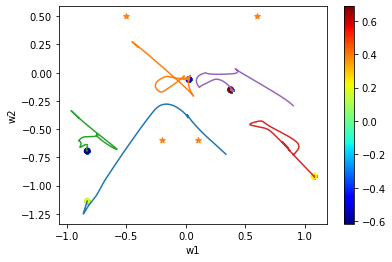

In [18]:
plt.scatter([w_in[0][0], w_in[1][0], w_in[2][0], w_in[3][0], w_in[4][0]],
            [w_in[0][1], w_in[1][1], w_in[2][1], w_in[3][1], w_in[4][1]], marker="P")
plot_trajectories()